In [144]:
import pandas as pd
import os
import sys
import optparse
import numpy as np
from scipy.integrate import solve_ivp
from timer import Timer
import math
from mpmath import whitw
import matplotlib.pyplot as plt

alpha = 0
Mpl = 1.

class GEF:
    def __init__(x, alpha, beta, Mpl, ini, M, ntr, SE, approx=False):
        x.units = False
        x.completed = False
        x.alpha = alpha
        x.beta = beta
        x.mass = M
        x.SE = SE
        x.vals = ini
        if (SE==None):
            x.GaugePos = 4
            x.conductivity = lambda y: 0., 0.
            x.vals["rhoChi"] = 0.
            x.vals["delta"] = 1.
            if(approx):
                x.Whittaker = x.WhittakerApprox_NoSE
            else:
                x.Whittaker = x.WhittakerExact
            #x.ODE = x.fullGEF_NoSE()
        else:
            x.GaugePos = 6
            if (SE=="mix"):
                if(approx):
                    x.Whittaker = x.WhittakerApprox_NoSE
                else:
                    x.Whittaker = x.WhittakerExact
                x.conductivity = x.ComputeImprovedSigma
            elif (-1. <= SE <=1.):
                if(approx):
                    x.Whittaker = x.WhittakerApprox_WithSE
                else:
                    x.Whittaker = x.WhittakerExact
                x.conductivity = x.ComputeSigmaCollinear
            else:
                print(SE, "is not a valid choice for SE")
        x.approx = approx
        x.ntr = ntr
        x.omega = 1.
        x.f = 1.
        #Need Unitful Potential once, to compute omega
        x.H0 = np.sqrt((0.5*x.vals["dphi"]**2 + x.potential())/(3*Mpl**2))
        x.Mpl = Mpl
        #Store H0 and Mpl separately to allow for toggling units
        x.omega = x.H0
        x.f = x.Mpl
        x.ratio = x.omega/x.f
    
    #Potentials and Couplings
    def potential(x):
        phi = x.f*x.vals["phi"]
        V = 0.5*phi**2*x.mass**2
        return V / (x.f*x.omega)**2
    
    def dVdphi(x):
        phi = x.f*x.vals["phi"]
        dV = phi*x.mass**2
        return dV/(x.f*x.omega**2)

    def dIdphi(x):
        phi = x.f*x.vals["phi"]
        dI = x.beta/x.f
        return dI*x.f

    def ddIddphi(x):
        phi = x.f*x.vals["phi"]
        ddI = 0.
        return ddI*x.f**2
    
    #Useful Quantities
    def FriedmannEq(x):
        Hsq = (1/3) * (0.5 * x.vals["dphi"]**2 + x.vals["a"]**(2*x.alpha)*
                       (x.potential() + x.ratio**2*(0.5*(x.vals["E"][0]+x.vals["B"][0]) + x.vals["rhoChi"])))
        return np.sqrt(Hsq)
    
    def GetXi(x):
        return (x.dIdphi() * x.vals["dphi"])/(2 * x.vals["H"])
    
    def GetS(x, sigma):
        return (x.vals["a"]**(x.alpha) * sigma)/(2* x.vals["H"])
    
    def ComputeSigmaCollinear(x):
        E0 = x.vals["E"][0]
        B0 = x.vals["B"][0]
        mu = ((E0+B0)/2)**(1/4)
        if mu==0:
            return 0., 0.
        else:
            sign = np.sign(x.vals["G"][0])
            mz = 91.2/(1.220932e19)
            gmz = 0.35
            gmu = np.sqrt(gmz**2/(1 + gmz**2*41./(48.*np.pi**2)*np.log(mz/(mu*x.ratio))))
            sigma = (41.*gmu**3/(72.*np.pi**2 * x.vals["H"] * np.tanh(np.pi*np.sqrt(B0/E0))))
            
            frac = x.SE
            fracE = (min(1., 1.- frac)*E0/(E0+B0) + max(-frac, 0.)*B0/(E0+B0))
            fracB = (min(1., 1.+ frac)*B0/(E0+B0) + max(frac,0.)*E0/(E0+B0))

            return fracE* np.sqrt(B0)*sigma, fracB* np.sqrt(E0)*sigma

    def ComputeImprovedSigma(x):
        E0 = x.vals["E"][0]
        B0 = x.vals["B"][0]
        G0 = x.vals["G"][0]
        mu = ((E0+B0)/2)**(1/4)
        if mu==0:
            x.vals["sigmaE"] = 0.
            x.vals["sigmaB"] = 0.
            return 0., 0.
        else:
            mz = 91.2/(1.220932e19)
            gmz = 0.35
            gmu = np.sqrt(gmz**2/(1 + gmz**2*41./(48.*np.pi**2)*np.log(mz/(mu*x.ratio))))

            Sigma = np.sqrt((E0 - B0)**2 + 4*G0**2)
            Eprime = np.sqrt(E0 - B0+Sigma)
            Bprime = np.sqrt(B0- E0+Sigma)
            Sum = E0 + B0 + Sigma

            sigma = (41.*gmu**3/(72.*np.pi**2)
                     /(np.sqrt(Sigma*Sum)*x.vals["H"] * np.tanh(np.pi*Bprime/Eprime)))
            
            return abs(G0)*Eprime*sigma, -G0*Bprime*sigma
        
    #Equations of Motions
    def EoMphi(x):
        alpha = x.alpha
        a = x.vals["a"]
        
        ddphiddt = ((alpha-3)*x.vals["H"] * x.vals["dphi"]
                - a**(2*alpha)*x.dVdphi() - a**(2*alpha)*x.dIdphi()*x.vals["G"][0]*x.ratio**2)
        return ddphiddt
    
    def EoMlnkh(x, ddphiddt):
        alpha = x.alpha
        a = x.vals["a"]
        H = x.vals["H"]
        sigmaE = x.vals["sigmaE"]
        sigmaB = x.vals["sigmaB"]
        kh = x.vals["kh"]
        
        xieff = x.vals["xieff"]
        s = x.GetS(sigmaE)
        r = (abs(xieff) + np.sqrt(xieff**2 + s**2 + s))
        
        fc = a**(1-alpha) * H * r

        dsigmaEdt = 0.
        dsigmaBdt = 0.
        #approximation: dHdt = alphaH**2 (slow-roll)
        fcprime = (((1-alpha)*H+a**(1-alpha)*alpha*H)*fc
                      + np.sign(xieff)*(a**(1-alpha)*(x.ddIddphi()*x.vals["dphi"]**2
                                                      + x.dIdphi()*ddphiddt)/2
                                           +a*(alpha*H*sigmaB + dsigmaBdt)/2
                                           - a**(1-alpha)*alpha*H**2*xieff)*
                   (1. + xieff/np.sqrt(xieff**2 + s**2 + s))
                      + (a*(alpha*H*sigmaE + dsigmaEdt)/2 
                         - a**(1-alpha)*alpha*H**2*s)*(abs(s) + 1/2)/np.sqrt(xieff**2 + s**2 + s))
        #fprime = f*H
        if (fcprime >= 0):
            if((kh-fc)/kh <=1e-3):
                dlnkhdt = fcprime/kh
            else:
                dlnkhdt = 0
        else:
            dlnkhdt = 0
    
        return dlnkhdt
    
    def EoMDelta(x):
        return -x.vals["a"]**(x.alpha)*x.vals["sigmaE"]*x.vals["delta"]
    
    def EoMrhoChi(x):
        return (x.vals["a"]**(x.alpha)*(x.vals["sigmaE"]*x.vals["E"][0]
                                        - x.vals["sigmaB"]*x.vals["G"][0])- 4*x.vals["H"]*x.vals["rhoChi"])
    
    def EoMF(x, dlnkhdt):
        prefac = dlnkhdt * x.vals["delta"] / (4*np.pi**2)
        
        aAlpha = x.vals["a"]**x.alpha
        H = x.vals["H"]
        E = x.vals["E"]
        B = x.vals["B"]
        G = x.vals["G"]
        sigmaE = x.vals["sigmaE"]
        scale = x.vals["kh"]/x.vals["a"]
        
        ScalarCpl = (x.dIdphi()*x.vals["dphi"]+aAlpha*x.vals["sigmaB"])
        
        
        Whitt = x.Whittaker()
        
        Whitt[2,1] = -Whitt[2,1]
        
        bdrF = prefac*np.array([[(scale)**(i+4)*(Whitt[j,0] + (-1)**i*Whitt[j,1]) for j in range(3)]
                                for i in range(x.ntr)])
        
        dFdt = np.zeros(bdrF.shape)
    
        for n in range(x.ntr-1):
            dFdt[n,0] = (bdrF[n, 0] - ((4+n)*H + 2*aAlpha * sigmaE)*E[n]
                         - 2*aAlpha*G[n+1] + 2*ScalarCpl*G[n])

            dFdt[n,1] = bdrF[n, 1] - ((4+n)*H)*B[n] + 2*aAlpha*G[n+1]

            dFdt[n,2] = (bdrF[n, 2] - ((4+n)*H + aAlpha * sigmaE)*G[n]
                         + aAlpha*(E[n+1] - B[n+1]) + ScalarCpl*B[n])

        dFdt[-1,0] = (bdrF[-1,0] -  ((4+x.ntr)*H + 2*aAlpha * sigmaE)*E[-1]
                        - 2*scale**2 * aAlpha*G[-2] + 2*ScalarCpl*G[-1])
        
        dFdt[-1,1] = bdrF[-1,1] - (4+x.ntr)*H*B[-1] + 2*scale**2 * aAlpha*G[-2]
        
        dFdt[-1,2] = (bdrF[-1,2] - ((4+x.ntr)*H + aAlpha * sigmaE)*G[-1] 
                         + scale**2 * aAlpha*(E[-2] - B[-2]) + ScalarCpl*B[-1])

        return dFdt
    
    #Whittaker Functions
    def WhittakerApprox_NoSE(x):
        xi = x.vals["xi"]
        if (abs(xi) >= 3):
            Fterm = np.zeros((3, 2))
            sgnsort = int((1-np.sign(xi))/2)

            xi = abs(xi)
            g1 = math.gamma(2/3)**2
            g2 = math.gamma(1/3)**2
            t1 = (3/2)**(1/3)*g1/(np.pi*xi**(1/3))
            t2 = -np.sqrt(3)/(15*xi)
            t3 = (2/3)**(1/3)*g2/(100*np.pi*xi**(5/3))
            t4 = (3/2)**(1/3)*g1/(1575*np.pi*xi**(7/3))
            t5 = -27*np.sqrt(3)/(19250*xi**3)
            t6 = 359*(2/3)**(1/3)*g2/(866250*np.pi*xi**(11/3))
            t7 = 8209*(3/2)**(1/3)*g1/(13162500*np.pi*xi**(13/3))
            t8 = -690978*np.sqrt(3)/(1861234375*xi**5)
            t9 = 13943074*(2/3)**(1/3)*g2/(127566140625*np.pi*xi**(17/3))
            Fterm[0, sgnsort] = t1+t2+t3+t4+t5+t6+t7+t8+t9

            t1 = 1
            t2 = -9/(2**(10)*xi**2)
            t3 = 2059/(2**(21)*xi**4)
            t4 = -448157/(2**31*xi**6)
            Fterm[0, 1-sgnsort] = np.sqrt(2)*(t1 + t2 + t3 + t4)

            t1 = (2/3)**(1/3)*g2*xi**(1/3)/(np.pi)
            t2 = 2*np.sqrt(3)/(35*xi)
            t3 = -4*(2/3)**(1/3)*g2/(225*np.pi*xi**(5/3))
            t4 = 9*(3/2)**(1/3)*g1/(1225*np.pi*xi**(7/3))
            t5 = 132*np.sqrt(3)/(56875*xi**3)
            t6 = -9511*(2/3)**(1/3)*g2/(5457375*np.pi*xi**(11/3))
            t7 = 1448*(3/2)**(1/3)*g1/(1990625*np.pi*xi**(13/3))
            t8 = 1187163*np.sqrt(3)/(1323765625*xi**5)
            t9 = -22862986*(2/3)**(1/3)*g2/(28465171875*np.pi*xi**(17/3))
            Fterm[1, sgnsort] = t1+t2+t3+t4+t5+t6+t7+t8+t9

            t1 = 1
            t2 = 11/(2**(10)*xi**2)
            t3 = -2397/(2**(21)*xi**4)
            t4 = 508063/(2**31*xi**6)
            Fterm[1, 1-sgnsort] = 1/np.sqrt(2)*(t1 + t2 + t3 + t4)

            t1 = 1/np.sqrt(3)
            t2 = -(2/3)**(1/3)*g2/(10*np.pi*xi**(2/3))
            t3 = 3*(3/2)**(1/3)*g1/(35*np.pi*xi**(4/3))
            t4 = -np.sqrt(3)/(175*xi**2)
            t5 = -41*(2/3)**(1/3)*g2/(34650*np.pi*xi**(8/3))
            t6 = 10201*(3/2)**(1/3)*g1/(2388750*np.pi*xi**(10/3))
            t7 = -8787*np.sqrt(3)/(21896875*xi**4)
            t8 = -1927529*(2/3)**(1/3)*g2/(4638768750*np.pi*xi**(14/3))
            t9 = 585443081*(3/2)**(1/3)*g1/(393158390625*np.pi*xi**(16/3))
            t10 = -65977497*np.sqrt(3)/(495088343750*xi**6)
            Fterm[2, sgnsort] = t1+t2+t3+t4+t5+t6+t7+t8+t9+t10

            t1 = 1
            t2 = -67/(2**(10)*xi**2)
            t3 = 21543/(2**(21)*xi**4)
            t4 = -6003491/(2**31*xi**6)
            Fterm[2, 1-sgnsort] = -np.sqrt(2)/(32*xi)*(t1 + t2 + t3 + t4) 
        else:
            Fterm = x.WhittakerExact()
        return Fterm
    
    def WhittakerApprox_WithSE(x):
        xieff = x.vals["xieff"]
        if (abs(xieff) >= 4):
            Fterm = np.zeros((3, 2))
            sgnsort = int((1-np.sign(xieff))/2)

            s = x.GetS(x.vals["sigmaE"])
            xi = abs(xieff)
            r = xi + np.sqrt(xi**2 + s**2 + s)
            psi = 2*np.sqrt(xi**2 + s**2 + s)/r
            rpsi = (psi/r**2)**(1/3)
            spsi = 5*s/psi**(2/3)
            
            g1 = math.gamma(2/3)**2
            g2 = math.gamma(1/3)**2
            
            t1 = 3**(1/3)*g1/np.pi
            t2 = -2/(5*np.sqrt(3))*(1+spsi)
            t3 = g2/(3**(1/3)*25*np.pi)*(1+spsi)**2
            t4 = 3**(1/3)*4*g1/(1575)*(1-27*spsi)
            t5 = 4*np.sqrt(3)/(875)*(-27/11+2*spsi + spsi**2)
            Fterm[0, sgnsort] = (psi/r)**(1/3)*(t1 + t2*rpsi + t3*rpsi**2 + t4*rpsi**3 + t5*rpsi**4)

            t1 = 1
            t2 = s/(16*xi**2)*(3*xi-r)/r
            t3 = s**2/(4*xi*r)
            Fterm[0, 1-sgnsort] = 2*np.sqrt(xi/r)*(t1 + t2 + t3)

            t1 = g2/(3**(1/3)*np.pi)
            t2 = 4*np.sqrt(3)/35
            t3 = -16*g2/(3**(1/3)*225*np.pi)
            Fterm[1, sgnsort] = (r/psi)**(1/3)*(t1 + t2*rpsi**2 + t3*rpsi**3)

            Fterm[1, 1-sgnsort] = 0.5*(r/xi)**(1/2)

            t1 = 1/np.sqrt(3)
            t2 = -g2/(3**(1/3)*5*np.pi)*(1+spsi)
            t3 = 3**(1/3)*6*g1/(35*np.pi)
            t4 = -4*np.sqrt(3)/(175)*(1+spsi)
            Fterm[2, sgnsort] = t1 + t2*rpsi + t3*rpsi**2 + t4*rpsi**3

            Fterm[2, 1-sgnsort] = -((3*xi -r)/xi + 8*s)/(16*np.sqrt(xi*r))
        else:
            Fterm = x.WhittakerExact()
        return Fterm
    
    def WhittakerExact(x):
        xieff = x.vals["xieff"]
        s = x.GetS(x.vals["sigmaE"])
        r = (abs(xieff) + np.sqrt(xieff**2 + s**2 + s))
        
        Whitt1Plus = whitw(-xieff*(1j), 1/2 + s, -2j*r)
        Whitt2Plus = whitw(1-xieff*(1j), 1/2 + s, -2j*r)

        Whitt1Minus = whitw(xieff*(1j), 1/2 + s, -2j*r)
        Whitt2Minus = whitw(1+xieff*(1j), 1/2 + s, -2j*r)
            
        exptermPlus = np.exp(np.pi*xieff)
        exptermMinus = np.exp(-np.pi*xieff)
        
        Fterm = np.zeros((3, 2))

        Fterm[0,0] = exptermPlus*abs((1j*r - 1j*xieff -s) * Whitt1Plus + Whitt2Plus)**2/r**2
        Fterm[0,1] = exptermMinus*abs((1j*r + 1j*xieff -s) * Whitt1Minus + Whitt2Minus)**2/r**2

        Fterm[1,0] = exptermPlus*abs(Whitt1Plus)**2
        Fterm[1,1] = exptermMinus*abs(Whitt1Minus)**2

        Fterm[2,0] = exptermPlus*((Whitt2Plus*Whitt1Plus.conjugate()).real - s * abs(Whitt1Plus)**2)/r
        Fterm[2,1]= exptermMinus*((Whitt2Minus*Whitt1Minus.conjugate()).real - s * abs(Whitt1Minus)**2)/r

        return Fterm             
            
    #Run GEF
    def InitialiseGEF(x):
        yini = np.zeros((x.ntr*3+x.GaugePos))
        yini[0] = 0
        yini[1] = x.vals["phi"]/x.f
        yini[2] = x.vals["dphi"]/(x.f*x.omega)
        yini[3] = np.log(abs(yini[2]*x.dIdphi()))
        if (x.SE != None):
            yini[4] = x.vals["delta"]
            yini[5] = x.vals["rhoChi"]
        yini
        #print(yini)
        return yini
    
    def TimeStep(x, t, y):
        x.DefineDictionary(t, y)
        dydt = np.zeros(y.shape)
        dydt[0] = x.vals["H"]
        dydt[1] = x.vals["dphi"]
        dydt[2] = x.EoMphi()
        dydt[3] = x.EoMlnkh(dydt[2])
        dFdt = x.EoMF(dydt[3])
        dydt[x.GaugePos:] = dFdt.reshape(x.ntr*3)

        if (x.SE != None):
            dydt[4] = x.EoMDelta()
            dydt[5] = x.EoMrhoChi()
        
        return dydt
    
    def SolveGEF(x):
        t = Timer()
        yini = x.InitialiseGEF()
        ODE = lambda t, y: x.TimeStep(t, y)
        t.start()
        sol = solve_ivp(ODE, [0,120], yini, method="RK45")
        t.stop()
        return sol
    
    def RunGEF(x):
        sol = x.SolveGEF()
        t = sol.t
        y = sol.y
        pars = x.vals.keys()
        res = dict(zip(pars, [[] for par in pars]))
        for i in range(len(t)):
            x.DefineDictionary(t[i], y[:,i])
            for par in pars:
                if (par in ["E", "B", "G"]):
                    res[par].append(x.vals[par][0])
                else:
                    res[par].append(x.vals[par])
        for par in pars:
            res[par] = np.array(res[par])
        x.vals = res
        x.completed = True
        return
    
    def Unitless(x):
        omega = x.H0
        f = x.Mpl
        if (not(x.completed)):
            print("You need to RunGEF or LoadGEF first")
            return
        if (x.units):
            x.vals["phi"] = x.vals["phi"]/f
            x.vals["dphi"] = x.vals["dphi"]/(f*omega)
            x.vals["H"] = x.vals["dphi"]/(omega)
            x.vals["E"] = x.vals["E"]/(omega)**4
            x.vals["B"] = x.vals["B"]/(omega)**4
            x.vals["G"] = x.vals["G"]/(omega)**4
            x.vals["sigmaE"] = x.vals["sigmaE"]/omega
            x.vals["sigmaB"] = x.vals["sigmaB"]/omega
            x.vals["kh"] = x.vals["kh"]/omega
            x.omega = omega
            x.f = f
            x.units = False
        else:
            print("Already Unitless")
        return
            
    def Unitful(x):
        omega = x.H0
        f = x.Mpl
        if (not(x.completed)):
            print("You need to RunGEF or LoadGEF first")
            return
        if (not(x.units)):
            x.vals["phi"] = x.vals["phi"]*f
            x.vals["dphi"] = x.vals["dphi"]*(f*omega)
            x.vals["H"] = x.vals["dphi"]*(omega)
            x.vals["E"] = x.vals["E"]*(omega)**4
            x.vals["B"] = x.vals["B"]*(omega)**4
            x.vals["G"] = x.vals["G"]*(omega)**4
            x.vals["sigmaE"] = x.vals["sigmaE"]*omega
            x.vals["sigmaB"] = x.vals["sigmaB"]*omega
            x.vals["kh"] = x.vals["kh"]/omega
            x.omega = 1.
            x.f = 1.
            x.units = True
        else:
            print("Already Unitful")
        return
      
    def DefineDictionary(x, t, y):
        x.vals["t"] = t
        x.vals["N"] = y[0]
        
        x.vals["a"]= np.exp(y[0])
        
        x.vals["phi"] = y[1]
        x.vals["dphi"] = y[2]
        x.vals["kh"] = np.exp(y[3])
        
        F = y[x.GaugePos:]
        F = F.reshape(x.ntr, 3)
        x.vals["E"] = F[:,0]
        x.vals["B"] = F[:,1]
        x.vals["G"] = F[:,2]
        
        if (x.SE == None):
            x.vals["H"] = x.FriedmannEq()
            x.vals["xi"] = x.GetXi()
            x.vals["xieff"] = x.vals["xi"]
        else:
            x.vals["delta"] = y[4]
            x.vals["rhoChi"] = y[5]
            x.vals["H"] = x.FriedmannEq()
            x.vals["sigmaE"], x.vals["sigmaB"] = x.conductivity()
            x.vals["xi"] = x.GetXi()
            x.vals["xieff"] = x.vals["xi"] + x.GetS(x.vals["sigmaB"])

In [145]:
alpha = 0
beta = 25.
Mpl = 1
M = 6e-6*Mpl
phi0 = 15.55*Mpl #in Pl units
dphidt0 = -np.sqrt(2/3)*M*Mpl
ntr = 56
SE = "mix"
dic = {"phi":phi0, "dphi":dphidt0, "delta":1., "rhoChi":0.}
G = GEF(alpha, beta, Mpl, dic, M, ntr, SE, approx=True)

You need to RunGEF or LoadGEF first


In [132]:
G.RunGEF()

Elapsed time: 52.0222 seconds


Already Unitful


(1e-17, 1e-14)

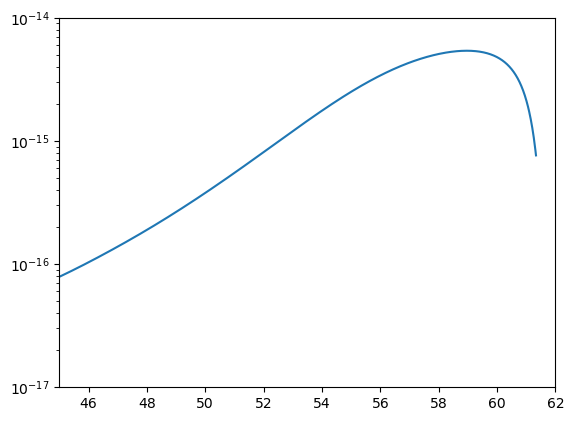

In [142]:
G.Unitful()

plt.plot(G.vals["N"], 0.5*G.vals["E"])
plt.yscale("log")
plt.xlim(45, 62)
plt.ylim(1e-17, 1e-14)

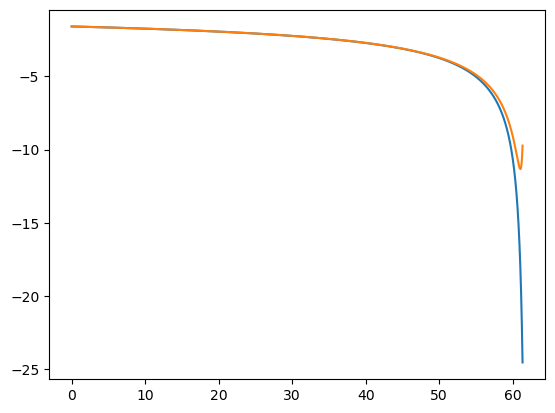

In [140]:
import matplotlib.pyplot as plt
plt.plot(G.vals["N"], G.vals["xi"])
plt.plot(G.vals["N"], G.vals["xieff"])

In [149]:
class ModebyMode:
    def __init__(x, GEF):
        x.GEF = GEF

In [150]:
M = MbM(G)

In [151]:
M.GEF.RunGEF()

Elapsed time: 50.0415 seconds
